### 1.Kütüphanelerin Import Edilmesi

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms as transforms
import random
import matplotlib.pyplot as plt

### 2.Verinin Çekilmesi ve Dönüşümünün Yapılması

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"You are using : {device}")

You are using : cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
train_data = torchvision.datasets.CIFAR10(
    root = "./data",
    train = True,
    transform = transform,
    download = True
)

test_data = torchvision.datasets.CIFAR10(
    root = "./data",
    train = False,
    transform = transform,
    download = True
)

100%|██████████| 170M/170M [00:20<00:00, 8.22MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 3.Verinin İncelenmesi

In [5]:
train_data, test_data

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [6]:
print(train_data.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [9]:
rand_num = random.randint(0, len(train_data))
train_img, train_label = train_data[rand_num]
train_img.shape, train_label

(torch.Size([3, 224, 224]), 4)

Text(0.5, 1.0, 'deer')

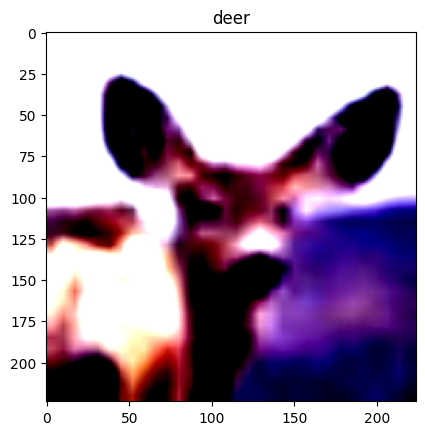

In [10]:
plt.imshow(train_img.permute(1,2,0))
plt.title(train_data.classes[train_label])

### 4.Model Mimarisinin Oluşturulması
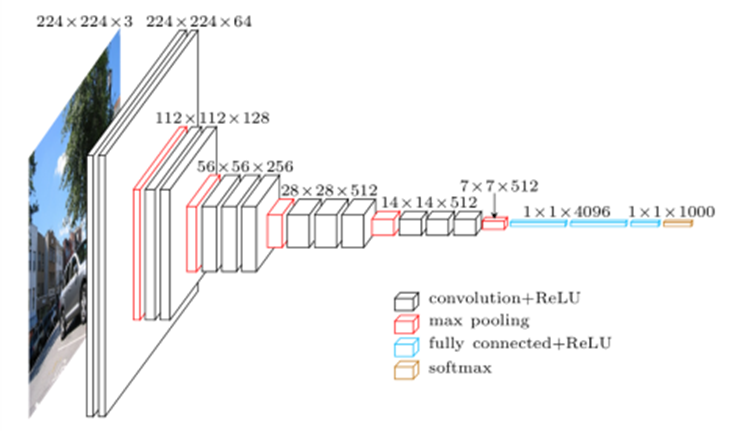
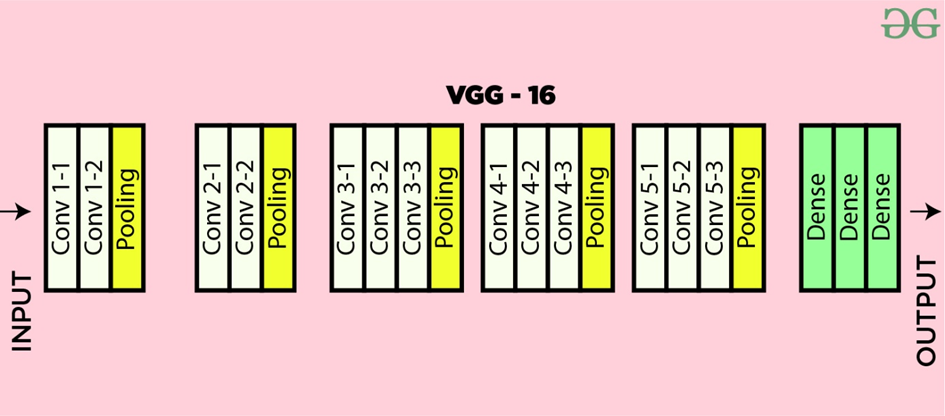

In [ ]:
class VGG(nn.Module):
  def __init__(self) -> None:
    super(VGG, self).__init__()
    self.layers = [64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M']
    self.arch = []
    in_channels = 3
    for layer in self.layers:
      if layer == 'M':
        self.arch.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
      else:
        self.arch.append(self.create_block(in_channels, layer, 1, 1, 3))
        in_channels = layer
    self.features = nn.Sequential(*self.arch)
    self.fc1 = nn.Linear(512*7*7, 4096)
    self.fc2 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, 10)

  def create_block(self,in_channels, out_channels, stride, padding, kernel_size):
    return nn.Sequential(
        nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size,
               stride = stride, padding = padding),
        nn.ReLU())

  def forward(self, x) -> torch.Tensor:
    x = self.features(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [45]:
model = VGG().to(device)
model

VGG(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (7): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (8): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3

In [39]:
rand_tens = torch.rand(1,3,224,224)
model(rand_tens)

tensor([[-0.0010,  0.0046, -0.0152,  0.0075,  0.0053, -0.0093, -0.0119,  0.0035,
         -0.0105, -0.0111]], grad_fn=<AddmmBackward0>)

### 5.DataLoader'ların Oluşturulması

In [41]:
train_dataloader = DataLoader(train_data, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 16, shuffle = False)

### 6.Model Eğitimi

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr = 10e-3)
loss_fn = nn.CrossEntropyLoss()

In [49]:
def train(model, trainloader, optim, loss_fn, epochs = 10):
  model.train()
  train_loss = []
  for epoch in range(epochs):
    avg_loss = 0.0
    total_loss = 0.0
    for batch, (X,y) in enumerate(trainloader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      optim.zero_grad()
      loss.backward()
      optim.step()
      total_loss += loss.item()
    avg_loss = total_loss/len(trainloader)
    print(f"Epoch : {epoch+1}, Loss : {avg_loss}")
    train_loss.append(avg_loss)
  return train_loss

In [50]:
def test(model, testloader, loss_fn):
  model.test()
  test_loss = []
  total_loss = 0.0
  avg_loss = 0.0
  with torch.no_grad():
    for batch, (X,y) in enumerate(testloader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      total_loss += loss.item()
    avg_loss = total_loss/len(testloader)
    test_loss.append(avg_loss)
  return test_loss


In [ ]:
train_losses = train(model, train_dataloader, optimizer, loss_fn)
train_losses

In [ ]:
test_losses = test(model, test_dataloader, loss_fn)
test_losses